In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


<h1 style="font-size: 90%; text-align: center;">ResNeXt Bottleneck Block (Core Building Unit)

Purpose:
This block implements the ResNeXt bottleneck (Form-C) exactly as described in the paper.

Key ideas implemented here:

Residual learning

Bottleneck structure (1×1 → 3×3 → 1×1)

Grouped convolution to realize cardinality

Shortcut projection when dimensions change

This is the main crux of the whole implementation, everything depends upon it </h1>


In [ ]:
class ResNeXtBottleneck(nn.Module):
    expansion = 4  # output channels = 4 × base channels

    def __init__(self, in_channels, base_channels, stride,
                 cardinality=8, base_width=4):
        super().__init__()

        # compute per-group width (paper formula)
        D = int(base_channels * (base_width / 64.0))
        C = cardinality
        group_width = D * C

        # 1×1 conv: reduce / prepare grouped channels
        self.conv1 = nn.Conv2d(in_channels, group_width,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)

        # 3×3 grouped convolution (KEY ResNeXt op)
        self.conv2 = nn.Conv2d(group_width, group_width,
                               kernel_size=3, stride=stride,
                               padding=1, groups=C, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)

        # 1×1 conv: expand back
        self.conv3 = nn.Conv2d(group_width,
                               base_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(base_channels * self.expansion)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != base_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,
                          base_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(base_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


<h1 style="font-size: 90%; text-align: center;">BLOCK 2 : ResNeXt Network for CIFAR

Purpose:
This assembles the full ResNeXt architecture using the bottleneck block.

Important CIFAR-specific decisions:

No 7×7 conv

No max-pool

Small spatial resolution preserved early

Depth rule: (depth − 2) / 9</h1>

In [ ]:
class ResNeXt(nn.Module):
    def __init__(self, depth=29, num_classes=10,
                 cardinality=8, base_width=4):
        super().__init__()
        assert (depth - 2) % 9 == 0, "Depth should be 29, 38, 47, etc."

        n_blocks = (depth - 2) // 9

        self.in_channels = 64

        # CIFAR stem (NO 7×7, NO maxpool)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNeXt stages
        self.layer1 = self._make_layer(64, n_blocks, stride=1,
                                       cardinality=cardinality,
                                       base_width=base_width)
        self.layer2 = self._make_layer(128, n_blocks, stride=2,
                                       cardinality=cardinality,
                                       base_width=base_width)
        self.layer3 = self._make_layer(256, n_blocks, stride=2,
                                       cardinality=cardinality,
                                       base_width=base_width)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256 * 4, num_classes)

    def _make_layer(self, base_channels, blocks, stride,
                    cardinality, base_width):
        layers = []
        layers.append(
            ResNeXtBottleneck(self.in_channels,
                              base_channels,
                              stride,
                              cardinality,
                              base_width)
        )
        self.in_channels = base_channels * 4

        for _ in range(1, blocks):
            layers.append(
                ResNeXtBottleneck(self.in_channels,
                                  base_channels,
                                  1,
                                  cardinality,
                                  base_width)
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root="./data", train=True,
                            download=True, transform=transform_train)
testset = datasets.CIFAR10(root="./data", train=False,
                           download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=256,
                         shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=256,
                        shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


<h1 style="font-size: 90%; text-align: center;">BLOCK 4 : Model, Optimizer, Scheduler, AMP

Purpose:
Configure training for fast but valid Colab execution.

Key choices:

SGD with momentum

Weight decay for regularization

Multi-step LR schedule

Mixed precision for speed</h1>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNeXt(depth=29,
                num_classes=10,
                cardinality=8,
                base_width=4).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.2,
    momentum=0.9,
    weight_decay=5e-4
)


scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[40, 80, 100],
    gamma=0.2
)

scaler = torch.amp.GradScaler(enabled=(device == "cuda"))



In [ ]:
best_acc = 0.0

def train(epoch):
    model.train()
    correct = total = 0

    for x, y in trainloader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    print(f"Epoch {epoch} | Train Acc: {100.*correct/total:.2f}%")


def test(epoch):
    global best_acc
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.cuda(), y.cuda()
            out = model(x)
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch} | Test Acc: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "resnext_best.pth")


In [ ]:
for epoch in range(1, 81):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch 1 | Train Acc: 17.45%
Epoch 1 | Test Acc: 22.70%
Epoch 2 | Train Acc: 25.34%
Epoch 2 | Test Acc: 27.40%
Epoch 3 | Train Acc: 30.39%
Epoch 3 | Test Acc: 31.18%
Epoch 4 | Train Acc: 37.58%
Epoch 4 | Test Acc: 40.86%
Epoch 5 | Train Acc: 44.69%
Epoch 5 | Test Acc: 39.84%
Epoch 6 | Train Acc: 51.76%
Epoch 6 | Test Acc: 48.35%
Epoch 7 | Train Acc: 58.74%
Epoch 7 | Test Acc: 31.71%
Epoch 8 | Train Acc: 63.75%
Epoch 8 | Test Acc: 54.13%
Epoch 9 | Train Acc: 67.75%
Epoch 9 | Test Acc: 56.73%
Epoch 10 | Train Acc: 69.81%
Epoch 10 | Test Acc: 55.44%
Epoch 11 | Train Acc: 71.37%
Epoch 11 | Test Acc: 65.69%
Epoch 12 | Train Acc: 72.86%
Epoch 12 | Test Acc: 63.82%
Epoch 13 | Train Acc: 74.73%
Epoch 13 | Test Acc: 57.98%
Epoch 14 | Train Acc: 76.59%
Epoch 14 | Test Acc: 65.30%
Epoch 15 | Train Acc: 77.78%
Epoch 15 | Test Acc: 57.82%
Epoch 16 | Train Acc: 78.68%
Epoch 16 | Test Acc: 72.97%
Epoch 17 | Train Acc: 79.37%
Epoch 17 | Test Acc: 67.06%
Epoch 18 | Train Acc: 80.18%
Epoch 18 | Test Acc:

In [ ]:
ls


data/  resnext_best.pth  sample_data/


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#Resnecxt impl
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, cardinality, base_width, stride=1):
        super().__init__()
        D = int(planes * (base_width / 64.0)) * cardinality

        self.conv1 = nn.Conv2d(in_planes, D, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(D)

        self.conv2 = nn.Conv2d(
            D, D, kernel_size=3, stride=stride,
            padding=1, groups=cardinality, bias=False
        )
        self.bn2 = nn.BatchNorm2d(D)

        self.conv3 = nn.Conv2d(
            D, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, planes * self.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return torch.relu(out)


class ResNeXt(nn.Module):
    def __init__(self, depth, num_classes, cardinality, base_width):
        super().__init__()
        assert (depth - 2) % 9 == 0
        n = (depth - 2) // 9

        self.in_planes = 64
        self.cardinality = cardinality
        self.base_width = base_width

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, n, stride=1)
        self.layer2 = self._make_layer(128, n, stride=2)
        self.layer3 = self._make_layer(256, n, stride=2)


        self.fc = nn.Linear(256 * Bottleneck.expansion, num_classes)

    def _make_layer(self, planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []

        for s in strides:
            layers.append(
                Bottleneck(
                    self.in_planes,
                    planes,
                    self.cardinality,
                    self.base_width,
                    s
                )
            )
            self.in_planes = planes * Bottleneck.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = torch.nn.functional.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        return self.fc(out)



# LOAD MODEL

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "./resnext_best.pth"

model = ResNeXt(
    depth=29,
    num_classes=10,
    cardinality=8,
    base_width=4
).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()


ResNeXt(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottlene

TEST


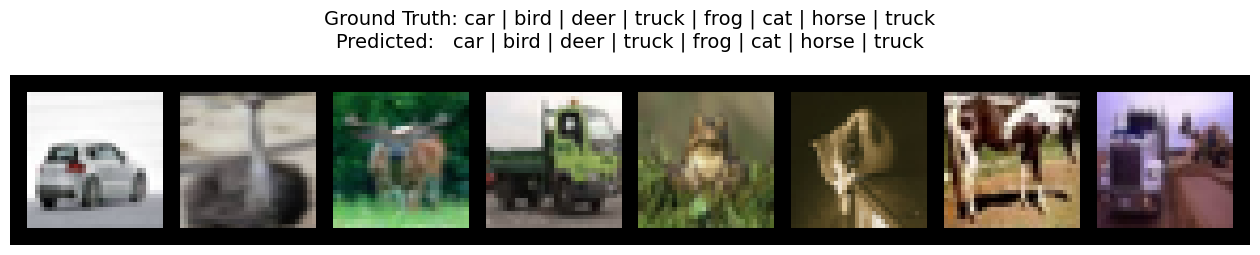

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "./resnext_best.pth"
num_display = 8

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# TEST DATA

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True
)

model = ResNeXt(
    depth=29,
    num_classes=10,
    cardinality=8,
    base_width=4
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


# INFERENCE

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)


images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()


# UNNORMALIZE (CIFAR-10)

mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)

images_display = images[:num_display].clone()
images_display = images_display * std + mean
images_display = torch.clamp(images_display, 0, 1)


#  GRID creation
-
grid_img = torchvision.utils.make_grid(
    images_display,
    nrow=num_display,
    padding=4
)

np_img = grid_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(16, 4))
plt.imshow(np_img)
plt.axis('off')

gt_text = ' | '.join(classes[labels[i]] for i in range(num_display))
pred_text = ' | '.join(classes[predicted[i]] for i in range(num_display))

plt.title(
    f"Ground Truth: {gt_text}\nPredicted:   {pred_text}",
    fontsize=14,
    pad=20
)

plt.show()


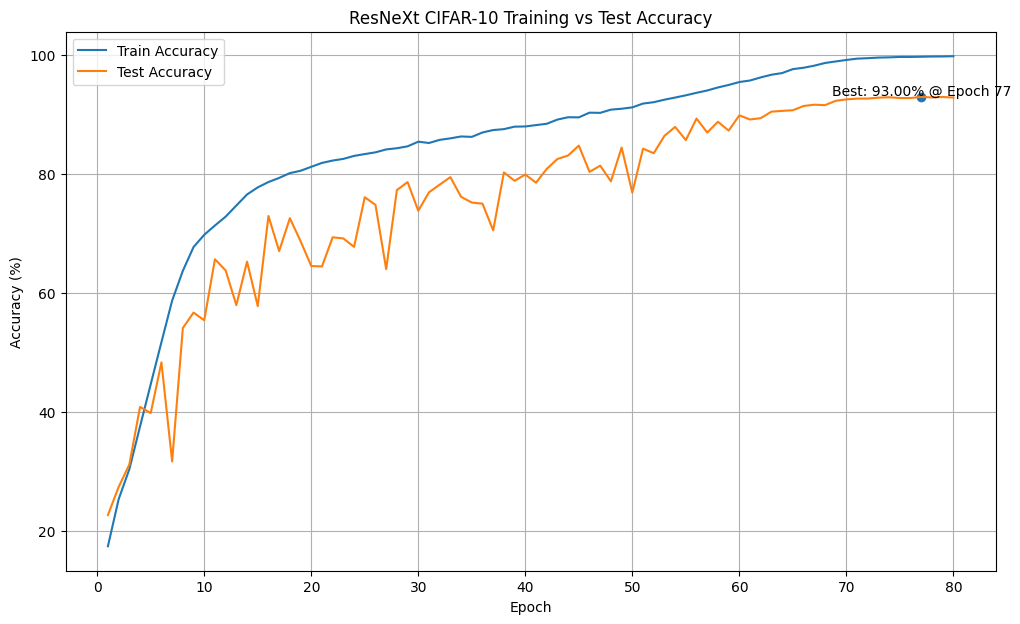

In [ ]:
import matplotlib.pyplot as plt


epochs = list(range(1, 81))


# TRAIN ACCURACY (FROM LOGS)

train_acc = [
    17.45, 25.34, 30.39, 37.58, 44.69,
    51.76, 58.74, 63.75, 67.75, 69.81,
    71.37, 72.86, 74.73, 76.59, 77.78,
    78.68, 79.37, 80.18, 80.57, 81.24,
    81.89, 82.29, 82.57, 83.07, 83.38,
    83.67, 84.16, 84.36, 84.68, 85.46,
    85.24, 85.77, 86.02, 86.34, 86.27,
    87.01, 87.42, 87.57, 87.99, 88.02,
    88.25, 88.47, 89.18, 89.57, 89.55,
    90.34, 90.31, 90.85, 91.00, 91.23,
    91.87, 92.10, 92.52, 92.88, 93.26,
    93.68, 94.07, 94.58, 95.00, 95.49,
    95.75, 96.27, 96.72, 97.00, 97.66,
    97.89, 98.24, 98.69, 98.95, 99.20,
    99.42, 99.50, 99.60, 99.64, 99.71,
    99.71, 99.74, 99.78, 99.79, 99.83
]

# TEST ACCURACY (FROM LOGS)
-
test_acc = [
    22.70, 27.40, 31.18, 40.86, 39.84,
    48.35, 31.71, 54.13, 56.73, 55.44,
    65.69, 63.82, 57.98, 65.30, 57.82,
    72.97, 67.06, 72.60, 68.74, 64.56,
    64.48, 69.39, 69.19, 67.78, 76.12,
    74.84, 64.04, 77.32, 78.67, 73.85,
    76.95, 78.24, 79.50, 76.19, 75.23,
    75.04, 70.55, 80.29, 78.88, 79.94,
    78.57, 80.88, 82.55, 83.14, 84.80,
    80.39, 81.43, 78.80, 84.48, 76.90,
    84.29, 83.52, 86.44, 87.95, 85.73,
    89.35, 87.00, 88.81, 87.32, 89.89,
    89.19, 89.42, 90.51, 90.64, 90.75,
    91.46, 91.68, 91.60, 92.33, 92.57,
    92.70, 92.71, 92.86, 92.93, 92.80,
    92.80, 93.00, 92.90, 92.98, 92.87
]


# BEST TEST ACCURACY

best_epoch = test_acc.index(max(test_acc)) + 1
best_acc = max(test_acc)


# PLOT

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, test_acc, label="Test Accuracy")

plt.scatter(best_epoch, best_acc)
plt.text(
    best_epoch,
    best_acc + 0.3,
    f"Best: {best_acc:.2f}% @ Epoch {best_epoch}",
    ha="center"
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ResNeXt CIFAR-10 Training vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.show()
